In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
from tempfile import gettempdir
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange   
import tensorflow as tf

from matplotlib import rcParams                  
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt

# matplotlib输出中文的时候会出现乱码，对matplotlib进行设置，使之可以输出中文
myfont =  FontProperties(fname='wqy-microhei.ttc',size=20)
rcParams['axes.unicode_minus']=False                             # 解决负号‘-‘显示为方块的问题


C:\Users\l\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# 读取文件，将文件中的句子转成词汇列表

filename = './QuanSongCi.txt'                      # 文件名
def read_data(filename):
    with open(filename, encoding="utf-8") as f:
        data = f.read()
        data = list(data)
    return data

vocabulary = read_data(filename)
print('Data size', len(vocabulary))

Data size 1903073


原文：潘阆酒泉子（十之一）长忆钱塘，不是人寰是天上。万家掩映翠微间。处处水潺潺。异花四季当窗放。出入分明在屏障。

read_data(filename)之后的vocabulary：          
['潘', '阆', '\n', '\n', '酒', '泉', '子', '（', '十', '之', '一', '）', '\n', '\n', '长', '忆', '钱', '塘', '，', '不', '是', '人', '寰', '是', '天', '上', '。', '万', '家', '掩', '映', '翠', '微', '间', '。', '处', '处', '水', '潺', '潺', '。', '\n', '\n', '异', '花', '四', '季', '当', '窗', '放', '。', '出', '入', '分', '明', '在', '屏', '障', '。', '别', '来', '隋', '柳', '几', '经', '秋', '。', '何', '日', '得', '重', '游', '。', '\n', '\n', '酒', '泉', '子', '（', '十', '之', '二', '）', '\n',

In [3]:
# 生成字典dictionary和reversed_dictionary
# data: 转换后的编码；count：每个词汇的频数统计；dictionary：词汇表；reversed_dictionary：词汇表的反转形式

vocabulary_size = 5000
words = vocabulary
n_words = vocabulary_size - 1

# count：每个词汇的频数统计，也就是词汇出现的次数（频数）
count = [['UNK', -1]]                       # 创建列表count,第一个元素是['UNK', -1],之后根据单词频数高低添加(extend)到count
count.extend(collections.Counter(words).most_common(n_words - 1))  # 使用collections.Counter统计词汇列表中词汇的频数
                                                                   # most_common方法取频数最高的5000个词汇 

print(count)    
count：每个词汇的频数统计，也就是词汇出现的次数（频数）    
[['UNK', -1], ('。', 149620), ('\n', 117070), ('，', 108451), ('、', 19612), ('人', 13607), ('花', 12809), ('风', 12568), ('一', 11301), ('（', 10967), ('）', 10967), ('春', 10956), ('不', 10186), ('天', 8049), ('月', 8029), ('无', 7873), ('云', 7539), ('山', 7342), ('来', 7210), ('有', 6514), ('香', 6346), ('时', 6338), ('江', 6296), ('年', 6243), ('水', 6161), 

In [4]:
# dictionary：词汇表，词汇及对应的词汇频数的排名数

dictionary = dict()                                     # 创建一个字典，将高频单词放入dictionary中， 并按词汇频数排名
for word, _ in count:                                  # word是对应的词汇，_是词汇的频数
    dictionary[word] = len(dictionary)                 # word是对应的词汇，值(value)是词汇频数的排名   
    

print(dictionary)     
dictionary：词汇表，词汇及对应的词汇频数的排名数     
{'UNK': 0, '。': 1, '\n': 2, '，': 3, '、': 4, '人': 5, '花': 6, '风': 7, '一': 8, '（': 9, '）': 10, '春': 11, '不': 12, '天': 13, '月': 14, '无': 15, '云': 16, '山': 17, '来': 18, '有': 19, '香': 20, '时': 21, '江': 22, '年': 23, '水': 24, '日': 25, '玉': 26, '清': 27, '如': 28, '是': 29, '何': 30, '红': 31, '归': 32, '处': 33, '相': 34, '上': 35, '中': 36, '雨': 37, '去': 38, '生': 39, '酒': 40, '长': 41, '金': 42, '谁': 43, '秋':

In [5]:
# get(word,0)的用法

for word in words[:20]:
    index = dictionary.get(word,0)
    # print([word,index])

['潘', 1503] 
['阆', 1828] 
['\n', 2] 
['\n', 2] 
['酒', 40]
['泉', 613]
['子', 47]
['（', 9]
['十', 111]
['之', 117]
['一', 8]
['）', 10]
['\n', 2]
['\n', 2]
['长', 41]
['忆', 310]
['钱', 981]
['塘', 657]
['，', 3]
['不', 12]

In [6]:
# data：文本中出现的词汇，按照原文本出现的顺序，词汇频数的排名

data = list()
unk_count = 0
for word in words:                      # 遍历文本中的词汇列表（原文本：words = vocabulary，word就是每个词汇）
    index = dictionary.get(word, 0)     # 如果word是dictionary的key，获取对应的value值赋值给index，如果没有value就对index赋值为0
                                        # 因为len(dictionary)=4999，不是原文中所有的word都会在dictionary中，没有的话就得赋值为0
    if index == 0:   
        unk_count += 1
    data.append(index)      # 把word频数的排名放入到列表data中，data中的数字就是按照原文本中出现的词汇顺序，词汇频数的排名

count[0][1] = unk_count     # 第一个[UNK']的值(value)赋值为index==0的总数值

print(data)      
data：文本中出现的词汇，按照原文本出现的顺序，词汇频数的排名      
[1503, 1828, 2, 2, 40, 613, 47, 9, 111, 117, 8, 10, 2, 2, 41, 310, 981, 657, 3, 12, 29, 5, 1635, 29, 13, 35, 1, 102, 110, 672, 505, 105, 286, 116, 1, 33, 33, 24, 2266, 2266, 1, 2, 2, 1117, 6, 326, 1545, 184, 185, 479, 1, 332, 205,

print(count)      
count：每个词汇的频数统计，也就是词汇出现的次数（频数）      
[['UNK', 1198], ('。', 149620), ('\n', 117070), ('，', 108451), ('、', 19612), ('人', 13607), ('花', 12809), ('风', 12568), ('一', 11301), ('（', 10967), ('）', 10967), ('春', 10956), ('不', 10186), ('天', 8049), ('月', 8029), ('无', 7873), ('云', 7539), ('山', 7342), ('来', 7210), ('有', 6514), ('香', 6346), ('时', 6338), ('江', 6296), ('年', 6243), ('水', 6161),

In [7]:
# reversed_dictionary：词汇表的反转形式，词汇频数的排名数和对应的词汇 

reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))  # 将key和value互换生成新的reversed_dictionary

# data: 转换后的编码；count：每个词汇的频数统计；dictionary：词汇表；reversed_dictionary：词汇表的反转形式

print(reversed_dictionary)    
{0: 'UNK', 1: '。', 2: '\n', 3: '，', 4: '、', 5: '人', 6: '花', 7: '风', 8: '一', 9: '（', 10: '）', 11: '春', 12: '不', 13: '天', 14: '月', 15: '无', 16: '云', 17: '山', 18: '来', 19: '有', 20: '香', 21: '时', 22: '江', 23: '年', 24: '水', 25: '日',

In [8]:
# 生成Word2Vec的训练样本
# 生成训练用的batch数据,batch_size是batch的大小,num_skips：对每个单词生成多少个样本
# skip_window是单词最远可以联系的距离，设为1代表只能跟紧邻的两个单词生成样本

batch_size=128 #8
num_skips=2; skip_window=1
data_index = 0

global data_index                    # 会反复调用generate_batch，所以要确保data_index可以在函数generate_batch中被修改
assert batch_size % num_skips == 0   # num_skips：对每个单词生成多少个样本，batch_size必须是它的整数倍
assert num_skips <= 2 * skip_window  # num_skips不能大于skip_window值的两倍，确保每个batch包含了一个词汇对应的所有样本
 
batch = np.ndarray(shape=(batch_size), dtype=np.int32)     # 用np.ndarray将batch和labels初始化为数组
labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32) # (1,8)的数组，数组里面的值是什么？ 

span = 2 * skip_window + 1                      # span是对某个单词创建相关样本时会使用到的单词数量，包括目标单词本身和前后单词
buffer = collections.deque(maxlen=span)         # 创建一个最大容量为span的deque,即双向队列,buffer = deque([], maxlen=3)
 
if data_index + span > len(data):                  # data_index + span = 3; len(data) = 1903073
    data_index = 0  
buffer.extend(data[data_index : data_index+span])  # 从序号data_index开始，把span个单词顺序读入buffer作为初始值
                                                   # data[0:3] = [1503,1828,2](data的前面3个数字)
                                                   # buffer = deque([1503, 1828, 2], maxlen=3)
                                                   # 在对deque添加变量时，只会保留最后插入的span个变量
data_index += span                                 

for i in range(batch_size // num_skips):         #  第一层循环，8//2=4，每次循环对一个目标单词生成样本
                                                  #  //表示整数除法,batch_size // num_skips表示循环次数   
    context_words = [w for w in range(span) if w != skip_window]    # span = 3,skip_window=1
    #  context_words = [0,2]  
    
    words_to_use = random.sample(context_words,num_skips)           # num_skips=2
    # words_to_use = [2,0] 或 [0,2]
    
    for j,context_word in enumerate(words_to_use):              # 第二层循环，每次循环对一个语境单词生成样本
        #  第一次：j= 0,context_word= 2
        # 第二次：j= 1,context_word= 0
        
        batch[i * num_skips + j] = buffer[skip_window]
        labels[i * num_skips + j,0] = buffer[context_word] 
    
    if data_index == len(data):
        buffer.extend(data[0:span]) 
        data_index = span 
    else:
        buffer.append(data[data_index])
        data_index += 1

data_index = (data_index + len(data) - span) % len(data)

当batch_size = 8:    
batch =
[      1828 1072693248          0 1072693248          0 1072693248
          0          0]   
labels =   
[[      1503]   
 [         0]    
 [1599436526]    
 [1645630477]    
 [1745310583]   
 [1825934317]   
 [1801670157]   
 [ 805468270]]    

In [50]:
for i in range(5):
    print(batch[i], reversed_dictionary[batch[i]],'--->', labels[i, 0], reversed_dictionary[labels[i, 0]])   

# 1828是目标单词“阆”的编号，这个单词对应的语境单词是“潘”

1828 阆 ---> 2 

1828 阆 ---> 1503 潘
2 
 ---> 2 

2 
 ---> 1828 阆
2 
 ---> 2 



In [10]:
# 训练模型
batch_size = 128      # 128作为词向量的维度
embedding_size = 128  # Dimension of the embedding vector，将词汇转为稠密向量的维度
skip_window = 1       # 词最远可以联系的距离，设为1代表只能跟紧邻的两个单词生成样本
num_skips = 2         # How many times to reuse an input to generate a label，对每个单词生成多少个样本
num_sampled = 64      # Number of negative examples to sample，训练时用来做负样本的噪声单词的数量

valid_size = 16     # Random set of words to evaluate similarity on，用来抽取的验证词汇数
valid_window = 100  # Only pick dev samples in the head of the distribution，验证词汇只从频数最高的100个词汇中抽取
valid_examples = np.random.choice(valid_window, valid_size, replace=False) # 验证数据，随机抽取一些频数最高的词汇
                                                                 # 看向量空间上跟它们最近的单词是否相关性比较高
                                                                 # np.random.choice函数随机抽取
# valid_examples = [95 70  0 54 47 78 77 68 71 23 99 94 22 41 87 67]

In [11]:
graph = tf.Graph()                               # 创建graph
with graph.as_default():                        # 设置为默认的graph
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32) # 将前面随机产生的valid_examples转为TensorFlow中的constant

    with tf.device('/cpu:0'):                                  # 限定所有计算在CPU上执行，因为有些操作在GPU上可能还没有实现
        embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
                                # tf.random_uniform()随机生成所有单词的词向量embeddings,词汇表大小为5000，向量维度为128，(5000,128)
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)   # tf.nn.embedding_lookup查找输入train_inputs对应的向量embed

        nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))  # tf.truncated_normal初始化NCE loss中的权重参数nce_weigths
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]))         # 初始化为0

    loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights,
                                         biases=nce_biases,
                                         labels=train_labels,
                                         inputs=embed,
                                         num_sampled=num_sampled,
                                         num_classes=vocabulary_size))

    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)       # 定义优化器为SGD

    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True)) # 计算嵌入向量embeddings的L2范数norm
    normalized_embeddings = embeddings / norm            # 再将embeddings除以其L2范数得到标准化后的normalized_embeddings
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)  # 查询验证词汇的嵌入向量
    similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)
                                                                           # 计算验证词汇的嵌入向量与词汇表中所有词汇的相似性
    init = tf.global_variables_initializer()


Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [12]:
# 开始训练
num_steps = 100001

with tf.Session(graph=graph) as session:
    init.run()
    print('Initialized')

    average_loss = 0
    for step in range(num_steps):                       # 在每步训练迭代中，先使用generate_batch生成一个batch的inputs和labels数据
        batch_inputs, batch_labels = batch,labels       # generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)   # 执行一次优化器运算（即一次参数更新）
        average_loss += loss_val                                            # 这一步训练的loss累积到average_loss

        if step % 2000 == 0:                                                # 每2000次循环，计算一下平均loss并显示出来
            if step > 0:
                average_loss /= 2000
            print('Average loss at step ', step, ': ', average_loss)
            average_loss = 0

        if step % 10000 == 0:            # 每100000次循环，计算一次验证单词与全部单词的相似度
            sim = similarity.eval()
            for i in range(valid_size):                             # valid_size=16，选择了16个词汇作为验证词汇
                valid_word = reversed_dictionary[valid_examples[i]] # 验证词汇，valid_examples是随机抽取的一些频数最高的词汇的数字
                top_k = 8                                           # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = 'Nearest to %s:' % valid_word             
                 
                for k in range(top_k):
                    close_word = reversed_dictionary[nearest[k]]   # 与每个验证单词最相似的8个单词
                    log_str = '%s %s,' % (log_str, close_word)
                print(log_str)
                
    final_embeddings = normalized_embeddings.eval()

# 以下显示结果：平均损失，与验证单词相似度最高的单词
# Nearest to 前: 刹, 乡, 峨, 论, 聪, 逊, 棼, 辂，表示与前相似度最高的8个单词是：刹, 乡, 峨, 论, 聪, 逊, 棼, 辂

Initialized
Average loss at step  0 :  204.4873504638672
Nearest to 前: 刹, 乡, 峨, 论, 聪, 逊, 棼, 辂,
Nearest to 明: 郴, 唾, 块, 籋, 堪, 吾, 队, 绽,
Nearest to 空: 品, 鹿, 东, 袜, 像, 谭, 姝, 碑,
Nearest to 今: 逢, 亏, 雾, 并, 飙, 蜕, 蔽, 笳,
Nearest to 水: 吹, 弇, 巑, 半, 涸, 辛, 临, 勾,
Nearest to 流: 桠, 匝, 蓑, 鬅, 蕉, 切, 乡, 制,
Nearest to 红: 爆, 蓝, 揩, 亻, /, 血, 瑟, 窨,
Nearest to 笑: 力, 豺, 陌, 巧, 痴, 瘴, 屿, 惬,
Nearest to 处: 衣, 犬, 舡, 飕, 对, 盎, 悦, 仞,
Nearest to 云: 唳, 的, 八, 铜, 忿, 涡, 颢, 蠡,
Nearest to 、: 贼, 先, 压, 忔, 悴, 濆, 灿, 袒,
Nearest to 见: 莎, 躔, 垫, 徊, 诡, 镜, 智, 猴,
Nearest to 酒: 诬, 燮, 戈, 惘, 歃, 渗, 寺, 盱,
Nearest to 君: 杠, 聆, 紞, 仕, 镛, 跳, 史, 弧,
Nearest to 夜: 锺, 铩, 诧, 阄, 少, 蝼, 缴, 笄,
Nearest to 山: 儋, 觅, 怎, 脑, 枝, 枋, 奇, 惹,
Average loss at step  2000 :  14.216988740831614
Average loss at step  4000 :  1.0793605592548847
Average loss at step  6000 :  1.0237553245425224
Average loss at step  8000 :  1.019504894822836
Average loss at step  10000 :  1.0145290859341622
Nearest to 前: 刹, 乡, 峨, 论, 聪, 逊, 棼, 辂,
Nearest to 明: 
, 处, 是, 。, 天, 万, 窗, 十,
Nearest to 空: 

Average loss at step  92000 :  0.9934135321080685
Average loss at step  94000 :  0.993705523699522
Average loss at step  96000 :  0.9930188788771629
Average loss at step  98000 :  0.9942450412511825
Average loss at step  100000 :  0.9967902089655399
Nearest to 前: 刹, 乡, 峨, 论, 聪, 逊, 棼, 辂,
Nearest to 明: 柳, 是, 万, 处, 十, 放, 一, 几,
Nearest to 空: 品, 鹿, 东, 袜, 像, 谭, 姝, 碑,
Nearest to 今: 逢, 亏, 雾, 并, 飙, 蜕, 蔽, 笳,
Nearest to 水: 潺, 在, 几, 屏, 当, 一, 。, 人,
Nearest to 流: 桠, 匝, 蓑, 鬅, 蕉, 切, 乡, 制,
Nearest to 红: 爆, 蓝, 揩, 亻, /, 血, 瑟, 窨,
Nearest to 笑: 力, 豺, 陌, 巧, 痴, 瘴, 屿, 惬,
Nearest to 处: 障, 
, 经, 。, 是, 出, 分, 放,
Nearest to 云: 唳, 的, 八, 铜, 忿, 涡, 颢, 蠡,
Nearest to 、: 贼, 先, 压, 忔, 悴, 濆, 灿, 袒,
Nearest to 见: 莎, 躔, 垫, 徊, 诡, 镜, 智, 猴,
Nearest to 酒: 之, 经, 。, 
, 花, 钱, 在, ，,
Nearest to 君: 杠, 聆, 紞, 仕, 镛, 跳, 史, 弧,
Nearest to 夜: 锺, 铩, 诧, 阄, 少, 蝼, 缴, 笄,
Nearest to 山: 儋, 觅, 怎, 脑, 枝, 枋, 奇, 惹,


In [13]:
# 可视化Word2Vec效果

def plot_with_labels(low_dim_embs, labels, filename):             # low_dim_embs是降维到2维的词汇的空间向量
    assert low_dim_embs.shape[0] >= len(labels),  'More labels than embeddings'
    plt.figure(figsize=(18, 18))   
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)                           # plt.scatter：显示词汇的位置
        plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom',
                 fontproperties=myfont)           # plt.annotate：展示词汇本身

    plt.savefig(filename)

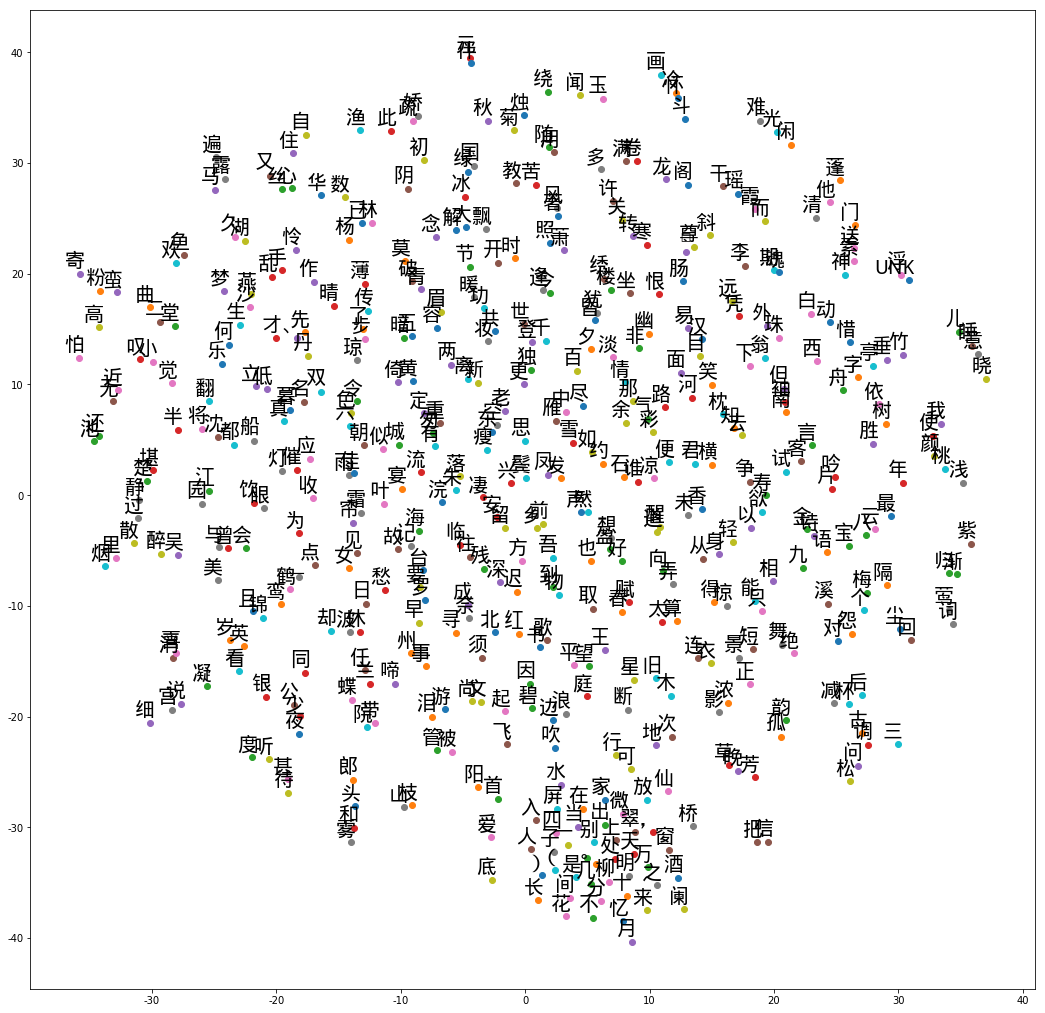

In [15]:
try: 
    from sklearn.manifold import TSNE             # 实现降维，将原始的128维嵌入向量降到2维
    import matplotlib.pyplot as plt

    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
    plot_only = 500                                                    # 展示词频最高的500个单词的可视化结果
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    labels = [reversed_dictionary[i] for i in range(plot_only)]
    plot_with_labels(low_dim_embs, labels,  'tsne.png')

except ImportError as ex:
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')
    print(ex)